# Substance Monitoring Using Substructure Search in RDKit

1. Convert Smiles to Molecules ()
2. Configure SMARTS query
3. Do substructure search

In [1]:
# import necessary libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

rdDepictor.SetPreferCoordGen(True)

In [2]:
##from https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/thread/CAHGTkV8sdfb4Q7FLn9C5MTwrqiJjHtnXK%2Bmz2SY3_4j2eAtevQ%40mail.gmail.com/#msg36477772
from rdkit.Chem.Draw import rdMolDraw2D

try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO


def DrawMolsZoomed(
    mols, legends, molsPerRow=3, subImgSize=(300, 300)
):  # , leg): #https://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html#rdkit.Chem.Draw.rdMolDraw2D.MolDraw2D
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow:
        nRows += 1
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    full_image = Image.new("RGBA", fullSize)
    for ii, mol in enumerate(mols):
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        le = legends[ii]
        column = ii % molsPerRow
        row = ii // molsPerRow
        offset = (column * subImgSize[0], row * subImgSize[1])
        d2d = rdMolDraw2D.MolDraw2DCairo(subImgSize[0], subImgSize[1])
        d2d.DrawMolecule(mol, legend=le)
        d2d.FinishDrawing()
        sub = Image.open(BytesIO(d2d.GetDrawingText()))
        full_image.paste(sub, box=offset)
    return full_image

In [3]:
smiles = [
    "CCO",
    "c1ccccc1",
    "CC(=O)O",
    "[Li+].F[As-](F)(F)(F)(F)F",
    "O[As](O)O",
    "CC1=CC=C(C=C1)S(=O)(=O)[N-]Cl.[Na+]",
    # "C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O",
]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
mylegend = [
    "ethanol",
    "benzene",
    "acetic acid",
    "lithium hexafluoroarsenate",
    "Arsen-III-oxid",
    "Chloramin T z.A.",
]

## 1. Depiction
Draw molecules to inspect their structure.

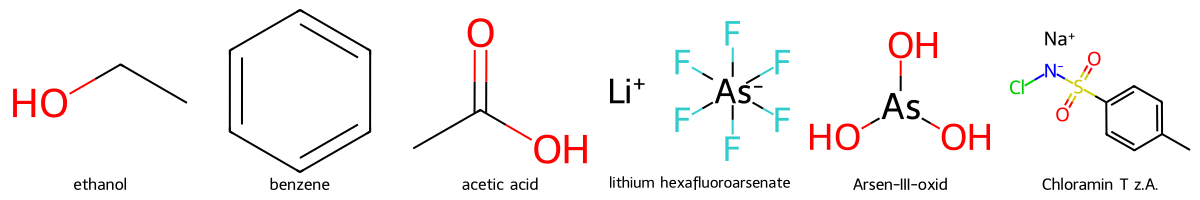

In [4]:
DrawMolsZoomed(
    mols,
    legends=mylegend,
    molsPerRow=6,
    subImgSize=(200, 200),
)

## 2. Substructure Search

### Search list of substances containing Arsenic.

Arsenic is listed in ECHA Annex XVII as Entry 19 (Restricted).

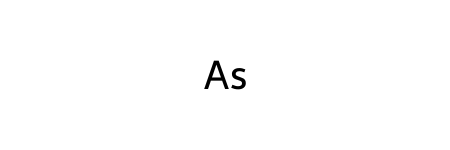

In [5]:
patt = Chem.MolFromSmarts("[As]")
patt

In [6]:
matches = [mol.HasSubstructMatch(patt) for mol in mols]
for myl, match in zip(mylegend, matches):
    print(f"{myl}: {match}")

ethanol: False
benzene: False
acetic acid: False
lithium hexafluoroarsenate: True
Arsen-III-oxid: True
Chloramin T z.A.: False


### Search list of substances containing carboxylic group

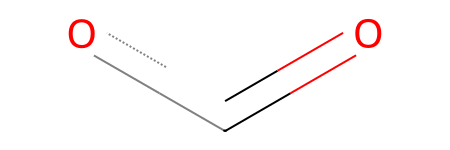

In [7]:
patt2 = Chem.MolFromSmarts("C(=O)O")
patt2

In [8]:
matches = [mol.HasSubstructMatch(patt2) for mol in mols]
for myl, match in zip(mylegend, matches):
    print(f"{myl}: {match}")

ethanol: False
benzene: False
acetic acid: True
lithium hexafluoroarsenate: False
Arsen-III-oxid: False
Chloramin T z.A.: False


((1, 2, 3),)


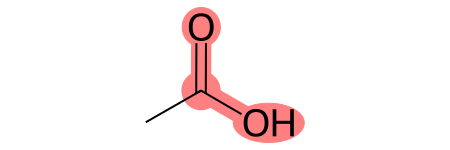

In [9]:
m = mols[2]
print(m.GetSubstructMatches(patt2))
m

## 3. Searching Chemical Groups restricted by ECHA

### Perfluoroheptanoic acid and its salts (SVHC Candidate)

* ECHA names 4 group members with CAS: 375-85-9, 20109-59-5, 6130-43-4, 21049-36-5
* What about other salts of perfluoroheptanoic acid?

In [10]:
phfpa_smiles = [
    "C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O",  # CAS given by ECHA
    "C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-].[Na+]",  # CAS given by ECHA
    "C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-].[NH4+] ",  # CAS given by ECHA
    "C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-].[K+]",  # CAS given by ECHA
    "COC(=O)C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F ",  # methyl perfluoheptanoate
    "C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-].[Cs+]",  # cesium salt
    "CCO",
    # "CCCOC(=O)C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F",  # propyl perfluoroheptanoate
    "CC1=CC=C(C=C1)S(=O)(=O)[N-]Cl.[Na+]",  # sodium p-toluenesulfonchloramide
    # "CCOC(=O)C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F",  # ethyl perfluoroheptanoate
]

In [11]:
phfpa_mols = [Chem.MolFromSmiles(smi) for smi in phfpa_smiles]
leg_phfpa = [
    "perfluoroheptanoic acid (375-85-9)",
    "sodium perfluoroheptanoate (20109-59-5)",
    "ammonium perfluoroheptanoate (6130-43-4)",
    "potassium perfluoroheptanoate (21049-36-5)",
    "methyl perfluoroheptanoate",
    "cesium perfluoroheptanoate",
    "ethanol",
    # "propyl perfluoroheptanoate",
    "sodium p-toluenesulfonchloramide",
    # "ethyl perfluoroheptanoate",
]

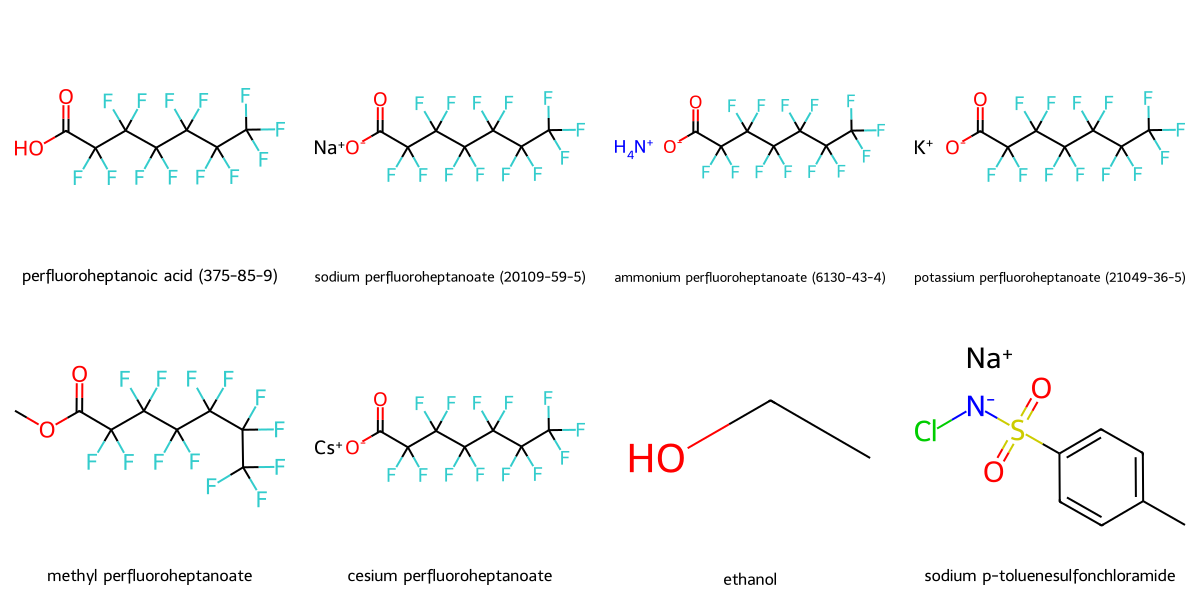

In [12]:
DrawMolsZoomed(phfpa_mols, legends=leg_phfpa, molsPerRow=4)

Define a query that would also match the cesium salt (falls under SVHC group but is not listed by ECHA):


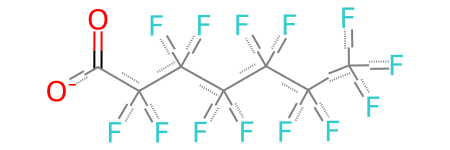

In [13]:
patt_pfas = Chem.MolFromSmarts("C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-]")
patt_pfas

In [14]:
matches = [phfpa_mol.HasSubstructMatch(patt_pfas) for phfpa_mol in phfpa_mols]
for leg, match in zip(leg_phfpa, matches):
    print(f"{leg}: {match}")

perfluoroheptanoic acid (375-85-9): False
sodium perfluoroheptanoate (20109-59-5): True
ammonium perfluoroheptanoate (6130-43-4): True
potassium perfluoroheptanoate (21049-36-5): True
methyl perfluoroheptanoate: False
cesium perfluoroheptanoate: True
ethanol: False
sodium p-toluenesulfonchloramide: False


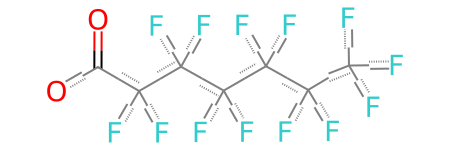

In [15]:
patt_pfas = Chem.MolFromSmarts("C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)[O]")
patt_pfas

In [16]:
matches = [phfpa_mol.HasSubstructMatch(patt_pfas) for phfpa_mol in phfpa_mols]
for leg, match in zip(leg_phfpa, matches):
    print(f"{leg}: {match}")

perfluoroheptanoic acid (375-85-9): True
sodium perfluoroheptanoate (20109-59-5): True
ammonium perfluoroheptanoate (6130-43-4): True
potassium perfluoroheptanoate (21049-36-5): True
methyl perfluoroheptanoate: True
cesium perfluoroheptanoate: True
ethanol: False
sodium p-toluenesulfonchloramide: False
